In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [14]:
import os
import sys

sys.path.append("../../../")

import getpass
import pickle
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from relativewealth import nightlights, settings
from relativewealth.dhs import generate_dhs_cluster_level_data
from relativewealth.feature_engineering import (
    categorize_wealth_index,
    generate_features,
)
from relativewealth.iso3 import get_region_name
from relativewealth.rollout_grids import get_region_filtered_bingtile_grids

# Model Prediction on Rollout Grids: Cambodia

This notebook is the final step in the rollout and runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value gives us the relative wealth level of an area compared to the rest of the country, which fixes the value range from 0 (lowest wealth) to 1 (highest wealth). In between these extremes, each area's wealth estimate is scaled to a value between 0 and 1.

The predicted relative wealth value is later binned into 5 wealth categories A-E by dividing the distribution into quintiles (every 20th percentile).

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [3]:
# Log-in using EOG credentials
username = os.environ.get("EOG_USER", None)
username = username if username is not None else input("Username?")
password = os.environ.get("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username, password, save_token=True)

2023-04-05 13:46:31.789 | INFO     | relativewealth.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-04-05 13:46:31.793 | INFO     | relativewealth.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Set country-specific parameters

In [4]:
COUNTRY_CODE = "kh"
COUNTRY_OSM = get_region_name(COUNTRY_CODE, code="alpha-2").lower()
OOKLA_YEAR = 2019
NIGHTLIGHTS_YEAR = 2016

rollout_date = "-".join(os.getcwd().split("/")[-2].split("-")[:3])
rollout_grids_path = Path(f"./{rollout_date}-{COUNTRY_CODE}-rollout-grids.geojson")
rollout_grids_path

Path('2023-02-21-kh-rollout-grids.geojson')

## Set Model Parameters

In [25]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f"./{rollout_date}-{COUNTRY_CODE}-single-country-model.pkl")

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_kh_generate_grids.ipynb` for documentation on generating this grid.

In [26]:
aoi = gpd.read_file(rollout_grids_path)
# aoi.explore()  # Uncomment to view data in a map

## Generate Features For Rollout AOI

In [27]:
%%time
rollout_aoi = aoi.copy()

# Create features dataframe using generate_features module
features = generate_features(
    rollout_aoi,
    country_osm=COUNTRY_OSM,
    ookla_year=OOKLA_YEAR,
    nightlights_year=NIGHTLIGHTS_YEAR,
    scale=False,
    features_only=True,
)

2023-04-05 14:41:32.864 | INFO     | relativewealth.osm:download_osm_country_data:199 - OSM Data: Cached data available for cambodia at /home/jace/.geowrangler/osm/cambodia? True
2023-04-05 14:41:32.866 | DEBUG    | relativewealth.osm:load_pois:161 - OSM POIs for cambodia being loaded from /home/jace/.geowrangler/osm/cambodia/gis_osm_pois_free_1.shp
2023-04-05 14:41:37.809 | INFO     | relativewealth.osm:download_osm_country_data:199 - OSM Data: Cached data available for cambodia at /home/jace/.geowrangler/osm/cambodia? True
2023-04-05 14:41:37.809 | DEBUG    | relativewealth.osm:load_roads:180 - OSM Roads for cambodia being loaded from /home/jace/.geowrangler/osm/cambodia/gis_osm_roads_free_1.shp
2023-04-05 14:41:47.525 | DEBUG    | relativewealth.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-05 14:41:47.526 | INFO     | relativewealth.ookla:load_type_year_data:94 - Cached data available at /home/jace/.geowrangler/ookla/processed/2465c710198cce764617e5dcd64daa3d.cs

CPU times: user 1min 9s, sys: 27.3 s, total: 1min 36s
Wall time: 1min 38s


## Inspect the generated features

In [28]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20137 entries, 0 to 20136
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   poi_count                          20137 non-null  float64
 1   atm_count                          20137 non-null  float64
 2   atm_nearest                        20137 non-null  float64
 3   bank_count                         20137 non-null  float64
 4   bank_nearest                       20137 non-null  float64
 5   bus_station_count                  20137 non-null  float64
 6   bus_station_nearest                20137 non-null  float64
 7   cafe_count                         20137 non-null  float64
 8   cafe_nearest                       20137 non-null  float64
 9   charging_station_count             20137 non-null  float64
 10  charging_station_nearest           20137 non-null  float64
 11  courthouse_count                   20137 non-n

## Run Model on AOI

### Load Model

In [ ]:
with open(MODEL_SAVE_PATH, "rb") as f:
    model = pickle.load(f)

### Make Predictions

In [31]:
rollout_aoi["Predicted Relative Wealth Index"] = model.predict(features.values)

## Binning predictions into wealth categories

Afterwards, we label the predicted relative wealth by binning them into 5 categories: `A`, `B`, `C`, `D`, and `E` where `A` is the highest and `E` is the lowest. 

We can create these wealth categories by splitting the output `Predicted Relative Wealth Index` distribution into 5 equally sized **quintiles**, i.e. every 20th percentile. 

This categorization may be modified to suit the context of the target country.

In [32]:
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"]
).astype(str)

### Save Output

In [34]:
%%time
rollout_aoi.to_file(
    f"{rollout_date}-{COUNTRY_CODE}-rollout-output.geojson",
    driver="GeoJSON",
    index=False,
)

CPU times: user 22.5 s, sys: 672 ms, total: 23.2 s
Wall time: 23.8 s


In [ ]:
# Join back raw features and save
rollout_output_with_features = rollout_aoi.join(features)
rollout_output_with_features.to_file(
    f"{rollout_date}-{COUNTRY_CODE}-rollout-output-with-features.geojson",
    driver="GeoJSON",
    index=False,
)

## Visualizations

### Inspect predicted relative wealth index and output dataframe

array([[<Axes: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

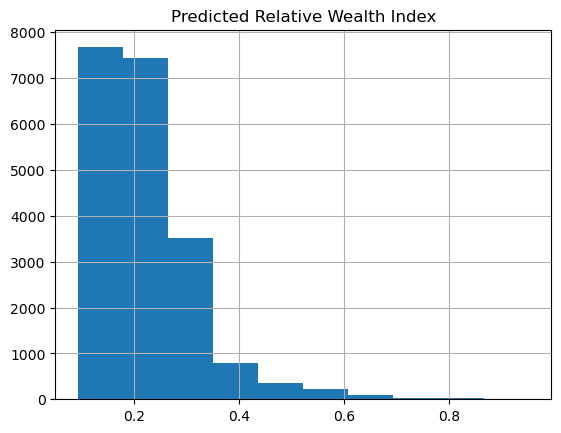

In [35]:
rollout_aoi[["Predicted Relative Wealth Index"]].hist()

In [36]:
rollout_aoi.head()

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,geometry,Predicted Relative Wealth Index,Predicted Wealth Category (quintile),...,mobile_2019_mean_avg_d_kbps_mean,mobile_2019_mean_avg_u_kbps_mean,mobile_2019_mean_avg_lat_ms_mean,mobile_2019_mean_num_tests_mean,mobile_2019_mean_num_devices_mean,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,13223001030111,Botum Sakor,None,KHM-ADM2-3_0_0-B77,KHM,ADM2,1.530576,"POLYGON ((103.16162 10.81172, 103.16162 10.833...",0.132976,E,...,0.0,0.0,0.0,0.0,0.0,-0.064363,0.013467,-0.025393,0.019338,-0.025305
1,13223001013222,Botum Sakor,None,KHM-ADM2-3_0_0-B77,KHM,ADM2,1.530576,"POLYGON ((103.18359 10.83331, 103.18359 10.854...",0.127728,E,...,0.0,0.0,0.0,0.0,0.0,-0.067641,0.010784,-0.029816,0.019521,-0.031274
2,13223001031000,Botum Sakor,None,KHM-ADM2-3_0_0-B77,KHM,ADM2,6.122304,"POLYGON ((103.18359 10.81172, 103.18359 10.833...",0.152541,E,...,0.0,0.0,0.0,0.0,0.0,-0.052187,0.015620,-0.017331,0.021790,-0.017005
3,13223001012210,Kiri Sakor,None,KHM-ADM2-3_0_0-B78,KHM,ADM2,8.403372,"POLYGON ((103.05176 10.89804, 103.05176 10.919...",0.181468,C,...,0.0,0.0,0.0,0.0,0.0,-0.006993,0.063116,0.020211,0.015892,0.017605
4,13223001012211,Kiri Sakor,None,KHM-ADM2-3_0_0-B78,KHM,ADM2,6.302529,"POLYGON ((103.07373 10.89804, 103.07373 10.919...",0.255417,B,...,0.0,0.0,0.0,0.0,0.0,-0.027030,0.075026,0.014192,0.026372,0.009149


### Create Static Maps
#### Plot Predicted Relative Wealth Index

<Figure size 640x480 with 0 Axes>

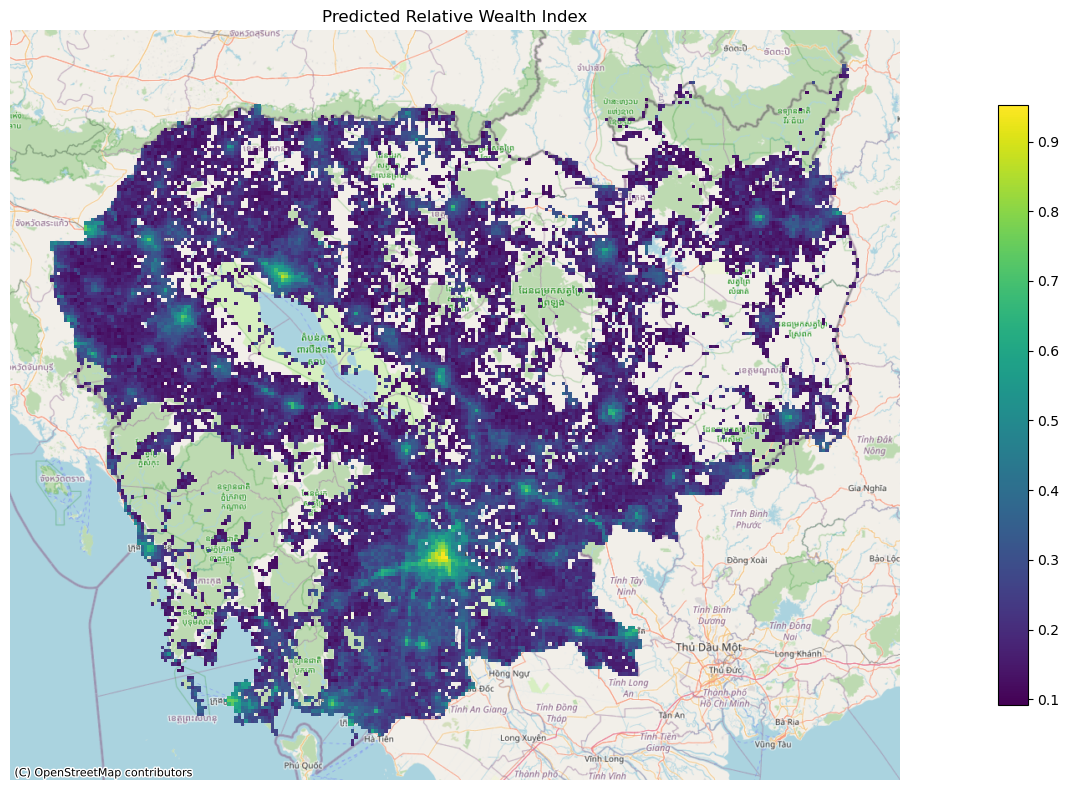

In [38]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot(
    "Predicted Relative Wealth Index",
    figsize=(20, 8),
    cmap="viridis",
    legend=True,
    legend_kwds={"shrink": 0.8},
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Index")
plt.tight_layout()
plt.savefig(f"{rollout_date}-{COUNTRY_CODE}-predicted-wealth-index.png")
plt.show()

#### Plot Predicted Relative Wealth Index Category

<Figure size 640x480 with 0 Axes>

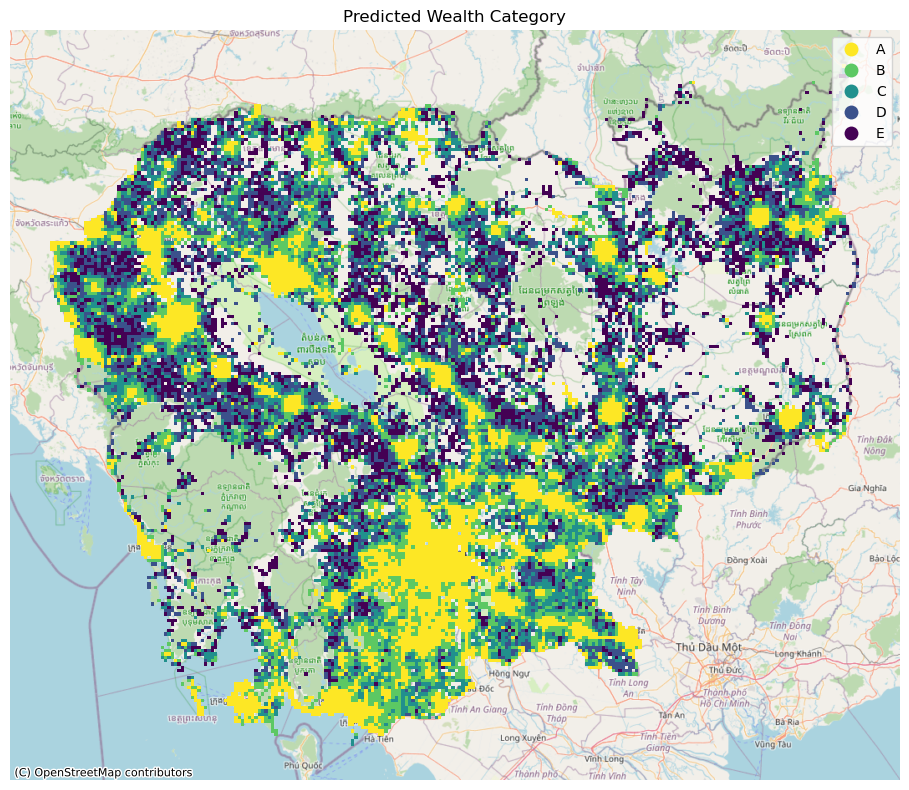

In [40]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot(
    "Predicted Wealth Category (quintile)",
    figsize=(20, 8),
    cmap="viridis_r",
    legend=True,
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Wealth Category")
plt.tight_layout()
plt.savefig(f"{rollout_date}-{COUNTRY_CODE}-predicted-wealth-bin.png")
plt.show()

### Create an Interactive Map

In [39]:
cols_of_interest = [
    "quadkey",
    "shapeName",
    "shapeGroup",
    "pop_count",
    "avg_rad_mean",
    "mobile_2019_mean_avg_d_kbps_mean",
    "fixed_2019_mean_avg_d_kbps_mean",
    "poi_count",
    "road_count",
    "Predicted Relative Wealth Index",
    "Predicted Wealth Category (quintile)",
]

# Warning: This can be a bit laggy due to the large amount of tiles being visualized

# Uncomment the ff if you want to viz the raw wealth predictions
# rollout_aoi.explore(column='Predicted Relative Wealth Index', tooltip=cols_of_interest, cmap="viridis")

# Uncomment the ff if you want to view the quintiles
# rollout_aoi.explore(column='Predicted Wealth Category (quintile)', tooltip=cols_of_interest, cmap="viridis_r")

Alternatively, you may also try to visualize this interactively in [Kepler](https://kepler.gl/demo) by uploading the rollout output geojson file.